In [ ]:
import google.auth

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [5]:
import os
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.preprocessing import LabelEncoder

In [6]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define file path
file_path = "/content/drive/My Drive/algae_data_11"

Mounted at /content/drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                                            Filepath     Label
0  /content/drive/My Drive/algae_data_11/nontoxic...  nontoxic
1  /content/drive/My Drive/algae_data_11/nontoxic...  nontoxic
2  /content/drive/My Drive/algae_data_11/nontoxic...  nontoxic
3  /content/drive/My Drive/algae_data_11/nontoxic...  nontoxic
4  /content/drive/My Drive/algae_data_11/Karenia/...   Karenia


<ipython-input-2-518daef1d103>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Label', data=data, order=classes, palette='Dark2')


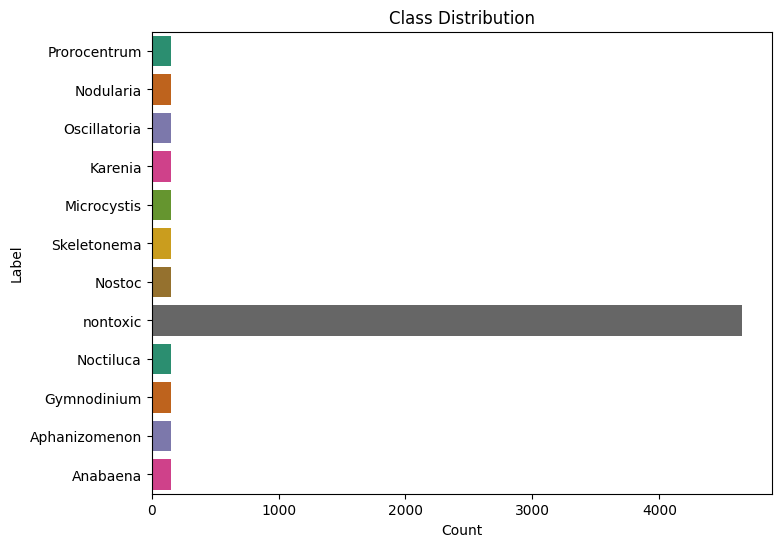

Found 3780 validated image filenames belonging to 12 classes.
Found 945 validated image filenames belonging to 12 classes.
Found 1575 validated image filenames belonging to 12 classes.
Epoch 1/10
30/30 [==============================] - 1059s 35s/step - loss: 1.0981 - accuracy: 0.7238 - val_loss: 0.6340 - val_accuracy: 0.7958
Epoch 2/10
30/30 [==============================] - 1003s 33s/step - loss: 0.4780 - accuracy: 0.8532 - val_loss: 0.4405 - val_accuracy: 0.8540
Epoch 3/10
30/30 [==============================] - 987s 33s/step - loss: 0.3438 - accuracy: 0.8926 - val_loss: 0.3713 - val_accuracy: 0.8899
Epoch 4/10
30/30 [==============================] - 986s 33s/step - loss: 0.2820 - accuracy: 0.9085 - val_loss: 0.3434 - val_accuracy: 0.8857
Epoch 5/10
30/30 [==============================] - 990s 33s/step - loss: 0.2550 - accuracy: 0.9228 - val_loss: 0.2983 - val_accuracy: 0.9005
Epoch 6/10
30/30 [==============================] - 1007s 34s/step - loss: 0.2199 - accuracy: 0.9376 - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


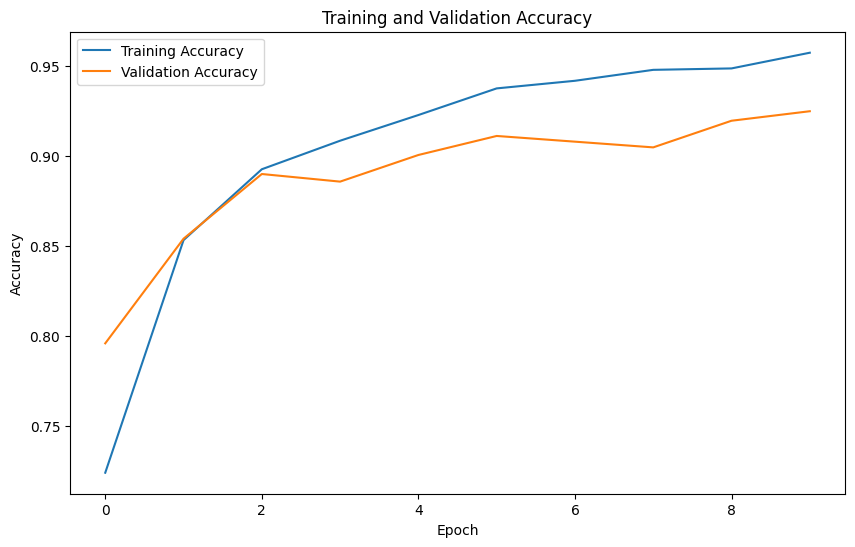

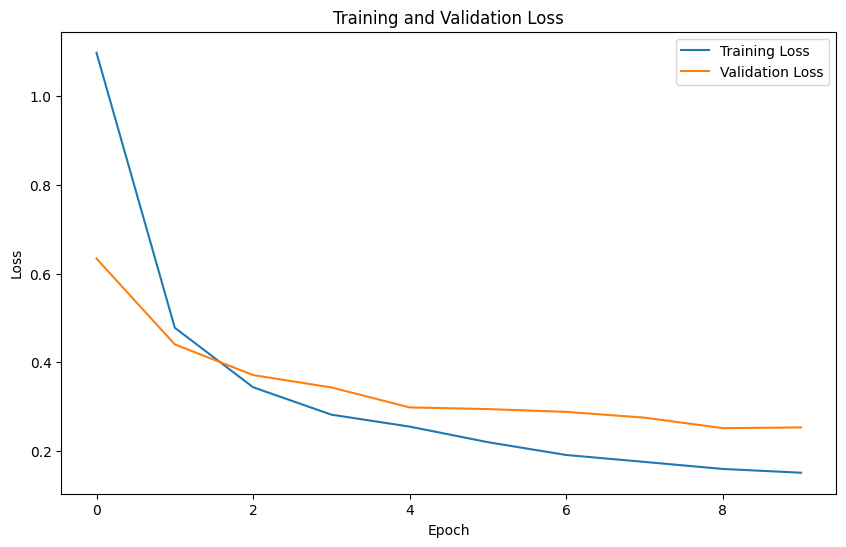

In [ ]:
import os
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define file path
file_path = "/content/drive/My Drive/algae_data_11"

# List of class names
classes = ['Prorocentrum', 'Nodularia', 'Oscillatoria', 'Karenia', 'Microcystis',
           'Skeletonema', 'Nostoc', 'nontoxic', 'Noctiluca', 'Gymnodinium',
           'Aphanizomenon', 'Anabaena']

# Get file paths and labels
filepaths = []
labels = []
for class_name in classes:
    class_files = glob.glob(os.path.join(file_path, class_name, '*.*'))
    filepaths.extend(class_files)
    labels.extend([class_name] * len(class_files))

# Create DataFrame
data = pd.DataFrame({'Filepath': filepaths, 'Label': labels})

# Shuffle the DataFrame
data = data.sample(frac=1).reset_index(drop=True)

# Display the first few rows of the DataFrame
print(data.head())

# Plot class distribution
plt.figure(figsize=(8, 6))
sns.countplot(y='Label', data=data, order=classes, palette='Dark2')
plt.xlabel('Count')
plt.title('Class Distribution')
plt.show()

# Train-test split
train, test = train_test_split(data, test_size=0.25, random_state=42)

# Data generators
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input,
                                   rotation_range=30,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   brightness_range=[0.4, 1.5],
                                   validation_split=0.2)

test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)

# Flow from DataFrame
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=128,
    shuffle=True,
    seed=42,
    subset='training'
)

valid_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=128,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=128,
    shuffle=False,
    seed=42
)

# Load pre-trained ResNet50 model
pretrained_model = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Freeze the pre-trained layers
pretrained_model.trainable = False

# Add custom classification layer
inputs = pretrained_model.input
outputs = Dense(len(classes), activation='softmax')(pretrained_model.output)
model = Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=10,
    batch_size=128,
    callbacks=[EarlyStopping(patience=3)]
)

# Save the model
model.save("algae_classification_model_2.h5")

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [7]:
name_class = os.listdir(file_path)
# name_class.remove('.DS_Store')
name_class

['Prorocentrum',
 'Nodularia',
 'Oscillatoria',
 'Karenia',
 'Microcystis',
 'Skeletonema',
 'Nostoc',
 'nontoxic',
 'Noctiluca',
 'Gymnodinium',
 'Aphanizomenon',
 'Anabaena']

In [8]:
import matplotlib.pyplot as plt

In [11]:
filepaths = list(glob.glob(file_path+'/**/*.*'))

In [12]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepath = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([filepath, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,Filepath,Label
0,/content/drive/My Drive/algae_data_11/Microcys...,Microcystis
1,/content/drive/My Drive/algae_data_11/nontoxic...,nontoxic
2,/content/drive/My Drive/algae_data_11/Aphanizo...,Aphanizomenon
3,/content/drive/My Drive/algae_data_11/nontoxic...,nontoxic
4,/content/drive/My Drive/algae_data_11/Noctiluc...,Noctiluca


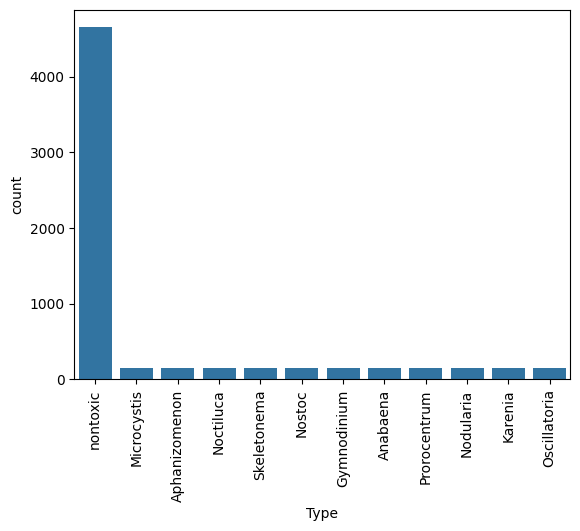

In [13]:
counts = data.Label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Type')
plt.xticks(rotation=90);

In [14]:
train, test = train_test_split(data, test_size=0.25, random_state=42)

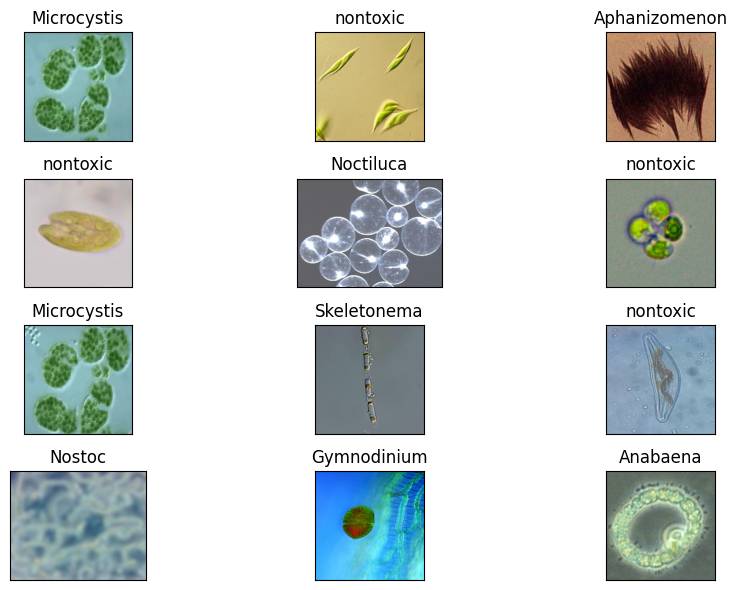

In [15]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10,6), subplot_kw={'xticks':[],'yticks':[]})
for i, ax in enumerate(axes.flat):
    if i < len(data.Filepath):
        ax.imshow(plt.imread(data.Filepath[i]))
        ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

Test Loss: 0.1990
Test Accuracy: 94.10%
13/13 [==============================] - 312s 24s/step
               precision    recall  f1-score   support

 Prorocentrum       0.80      0.65      0.72        37
    Nodularia       1.00      0.93      0.96        41
 Oscillatoria       0.83      0.61      0.70        33
      Karenia       0.94      0.82      0.87        38
  Microcystis       0.89      0.79      0.84        39
  Skeletonema       0.90      1.00      0.95        52
       Nostoc       1.00      0.74      0.85        35
     nontoxic       0.77      0.87      0.82        39
    Noctiluca       0.94      0.81      0.87        36
  Gymnodinium       0.95      0.95      0.95        39
Aphanizomenon       0.96      0.80      0.87        30
     Anabaena       0.95      0.98      0.97      1156

     accuracy                           0.94      1575
    macro avg       0.91      0.83      0.86      1575
 weighted avg       0.94      0.94      0.94      1575



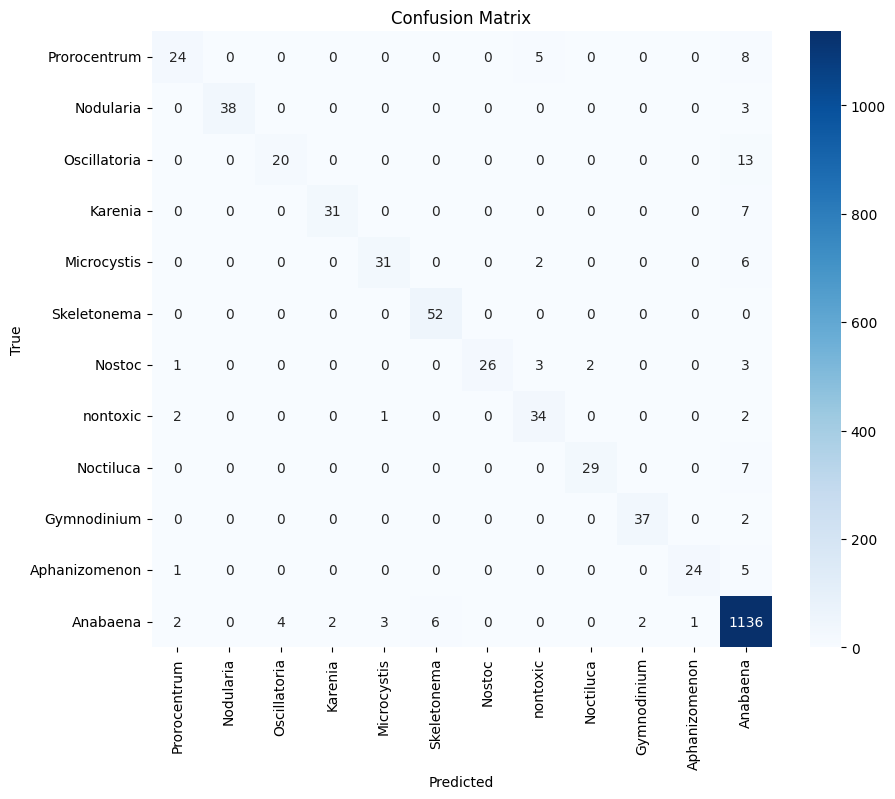

Accuracy: 0.94


In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_gen, verbose=0)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Generate predictions
predictions = model.predict(test_gen)
y_pred = np.argmax(predictions, axis=1)
y_true = test_gen.classes

# Classification report
print(classification_report(y_true, y_pred, target_names=classes))

# Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Accuracy score
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.2f}')

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import multilabel_confusion_matrix

In [ ]:
auc_pred = model.predict(test_gen)

13/13 [==============================] - 336s 24s/step


In [ ]:
from sklearn.preprocessing import LabelBinarizer

13/13 [==============================] - 319s 24s/step


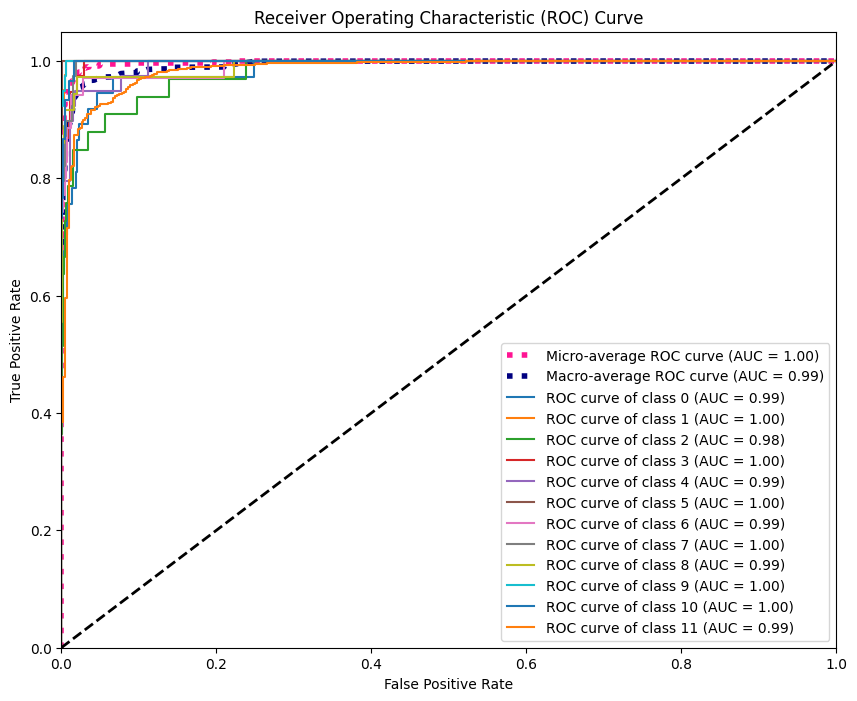

In [ ]:
# Convert labels to one-hot encoded format
label_binarizer = LabelBinarizer()
auc_y_true = label_binarizer.fit_transform(y_true)

# Convert predictions to probabilities
auc_pred = model.predict(test_gen)

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(auc_y_true.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(auc_y_true[:, i], auc_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(auc_y_true.ravel(), auc_pred.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Compute macro-average ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(auc_y_true.shape[1])]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(auc_y_true.shape[1]):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= auc_y_true.shape[1]
fpr_macro = all_fpr
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average ROC curve (AUC = {roc_auc_micro:0.2f})', color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr_macro, tpr_macro, label=f'Macro-average ROC curve (AUC = {roc_auc_macro:0.2f})', color='navy', linestyle=':', linewidth=4)

for i in range(auc_y_true.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
